#  Amazon Electronics Sales Data Analytics

This notebook performs **EDA and Cleaning** on the Amazon dataset (42K+ items, 17 features).

Steps:
1. Load dataset (cleaned & uncleaned).
2. Quick profiling.
3. Cleaning transformations.
4. Feature engineering.
5. Exploratory Data Analysis (EDA).
6. Business insights documentation.


In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Load datasets
clean = pd.read_csv('amazon_products_sales_data_cleaned.csv')
raw = pd.read_csv('amazon_products_sales_data_uncleaned.csv')


print('Cleaned shape:', clean.shape)
print('Uncleaned shape:', raw.shape)
clean.head()

Cleaned shape: (42675, 17)
Uncleaned shape: (42675, 16)


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,product_image_url,product_page_url,data_collected_at,product_category,discount_percentage
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,2025-09-01,Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Phones,43.60
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,2025-08-29,NaN,https://m.media-amazon.com/images/I/61nbF6aVIP...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,37.52
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,2025-09-01,NaN,https://m.media-amazon.com/images/I/61h78MEXoj...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,10.03
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61SUj2aKoE...,https://www.amazon.com/Apple-Cancellation-Tran...,2025-08-21 11:14:29,Phones,0.00
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61bMNCeAUA...,https://www.amazon.com/Apple-MX542LL-A-AirTag-...,2025-08-21 11:14:29,Phones,0.00


##  Quick Profiling

In [6]:
def quick_profile(df):
    print("Shape:", df.shape)
    print("\n--- Info ---")
    print(df.info())
    print("\n--- Missing Values (%) ---")
    print(df.isna().mean().sort_values(ascending=False).head(10))
    print("\n--- Unique Values ---")
    print(df.nunique().sort_values(ascending=False).head(10))

# Profile uncleaned dataset
quick_profile(raw)


Shape: (42675, 16)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42675 entries, 0 to 42674
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     42675 non-null  object
 1   rating                    41651 non-null  object
 2   number_of_reviews         41651 non-null  object
 3   bought_in_last_month      39458 non-null  object
 4   current/discounted_price  30926 non-null  object
 5   price_on_variant          42675 non-null  object
 6   listed_price              42675 non-null  object
 7   is_best_seller            42675 non-null  object
 8   is_sponsored              42675 non-null  object
 9   is_couponed               42675 non-null  object
 10  buy_box_availability      28022 non-null  object
 11  delivery_details          30955 non-null  object
 12  sustainability_badges     3408 non-null   object
 13  image_url                 42675 non-null  o

##  Data Cleaning (Uncleaned file)

In [7]:
df = raw.copy()

# ---- Currency ko numeric mein convert karna ----
def to_num(x):
    return str(x).replace(',', '').replace('₹','').replace('$','').replace('Rs.','').strip()

for col in ['discounted_price','original_price']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].map(to_num), errors='coerce')

# ---- Discount percentage recalc ----
if 'discounted_price' in df.columns and 'original_price' in df.columns:
    df['discount_pct_calc'] = 100 * (1 - df['discounted_price'] / df['original_price'])
    if 'discount_percentage' in df.columns:
        df['discount_percentage'] = df['discount_percentage'].fillna(df['discount_pct_calc']).clip(0,100)

# ---- Boolean conversion ----
for c in ['is_best_seller','is_sponsored','has_coupon','buy_box_availability']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.lower().isin(['true','1','yes'])

# ---- Dates conversion ----
for c in ['delivery_date','data_collected_at']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# ---- Duplicates remove karna (same product ka latest record rakhna) ----
if 'product_page_url' in df.columns and 'data_collected_at' in df.columns:
    df = df.sort_values('data_collected_at').drop_duplicates('product_page_url', keep='last')

print("Cleaned uncleaned dataset shape:", df.shape)
df.head()


Cleaned uncleaned dataset shape: (42675, 16)


,title,rating,number_of_reviews,bought_in_last_month,current/discounted_price,price_on_variant,listed_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6 out of 5 stars,375,300+ bought in past month,89.68,basic variant price: 2.4GHz,$159.00,False,False,Save 15% with coupon,False,"Delivery Mon, Sep 1",Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,/sspa/click?ie=UTF8&spc=MTo4NzEzNDY2NTQ5NDYxND...,2025-08-21 11:14:29
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3 out of 5 stars,"2,457",6K+ bought in past month,9.99,basic variant price: nan,$15.99,False,False,No Coupon,False,"Delivery Fri, Aug 29",NaN,https://m.media-amazon.com/images/I/61nbF6aVIP...,/sspa/click?ie=UTF8&spc=MTo4NzEzNDY2NTQ5NDYxND...,2025-08-21 11:14:29
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6 out of 5 stars,"3,044",2K+ bought in past month,314.00,basic variant price: nan,$349.00,False,False,No Coupon,False,"Delivery Mon, Sep 1",NaN,https://m.media-amazon.com/images/I/61h78MEXoj...,/sspa/click?ie=UTF8&spc=MTo4NzEzNDY2NTQ5NDYxND...,2025-08-21 11:14:29
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6 out of 5 stars,"35,882",10K+ bought in past month,NaN,basic variant price: $162.24,No Discount,False,False,No Coupon,False,NaN,NaN,https://m.media-amazon.com/images/I/61SUj2aKoE...,/Apple-Cancellation-Transparency-Personalized-...,2025-08-21 11:14:29
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8 out of 5 stars,"28,988",10K+ bought in past month,NaN,basic variant price: $72.74,No Discount,False,False,No Coupon,False,NaN,NaN,https://m.media-amazon.com/images/I/61bMNCeAUA...,/Apple-MX542LL-A-AirTag-Pack/dp/B0D54JZTHY/ref...,2025-08-21 11:14:29


##  Feature Engineering

In [8]:
# Discount ka actual amount
if 'original_price' in df.columns and 'discounted_price' in df.columns:
    df['discount_amount'] = df['original_price'] - df['discounted_price']

# Deep discount flag
if 'discount_percentage' in df.columns:
    df['is_deep_discount'] = df['discount_percentage'] >= 40

# Rating bucket
if 'product_rating' in df.columns:
    df['rating_bucket'] = pd.cut(df['product_rating'], 
                                 bins=[0,3,4,4.5,5], 
                                 labels=['Low(<=3)','OK(3-4)','Good(4-4.5)','Top(>4.5)'])

# Log transformation for skewed reviews data
if 'total_reviews' in df.columns:
    df['log_reviews'] = np.log1p(df['total_reviews'].clip(lower=0))

df.head()


,title,rating,number_of_reviews,bought_in_last_month,current/discounted_price,price_on_variant,listed_price,is_best_seller,is_sponsored,is_couponed,buy_box_availability,delivery_details,sustainability_badges,image_url,product_url,collected_at
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6 out of 5 stars,375,300+ bought in past month,89.68,basic variant price: 2.4GHz,$159.00,False,False,Save 15% with coupon,False,"Delivery Mon, Sep 1",Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,/sspa/click?ie=UTF8&spc=MTo4NzEzNDY2NTQ5NDYxND...,2025-08-21 11:14:29
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3 out of 5 stars,"2,457",6K+ bought in past month,9.99,basic variant price: nan,$15.99,False,False,No Coupon,False,"Delivery Fri, Aug 29",NaN,https://m.media-amazon.com/images/I/61nbF6aVIP...,/sspa/click?ie=UTF8&spc=MTo4NzEzNDY2NTQ5NDYxND...,2025-08-21 11:14:29
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6 out of 5 stars,"3,044",2K+ bought in past month,314.00,basic variant price: nan,$349.00,False,False,No Coupon,False,"Delivery Mon, Sep 1",NaN,https://m.media-amazon.com/images/I/61h78MEXoj...,/sspa/click?ie=UTF8&spc=MTo4NzEzNDY2NTQ5NDYxND...,2025-08-21 11:14:29
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6 out of 5 stars,"35,882",10K+ bought in past month,NaN,basic variant price: $162.24,No Discount,False,False,No Coupon,False,NaN,NaN,https://m.media-amazon.com/images/I/61SUj2aKoE...,/Apple-Cancellation-Transparency-Personalized-...,2025-08-21 11:14:29
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8 out of 5 stars,"28,988",10K+ bought in past month,NaN,basic variant price: $72.74,No Discount,False,False,No Coupon,False,NaN,NaN,https://m.media-amazon.com/images/I/61bMNCeAUA...,/Apple-MX542LL-A-AirTag-Pack/dp/B0D54JZTHY/ref...,2025-08-21 11:14:29


In [18]:
df = clean.copy()


##  EDA: Business Questions

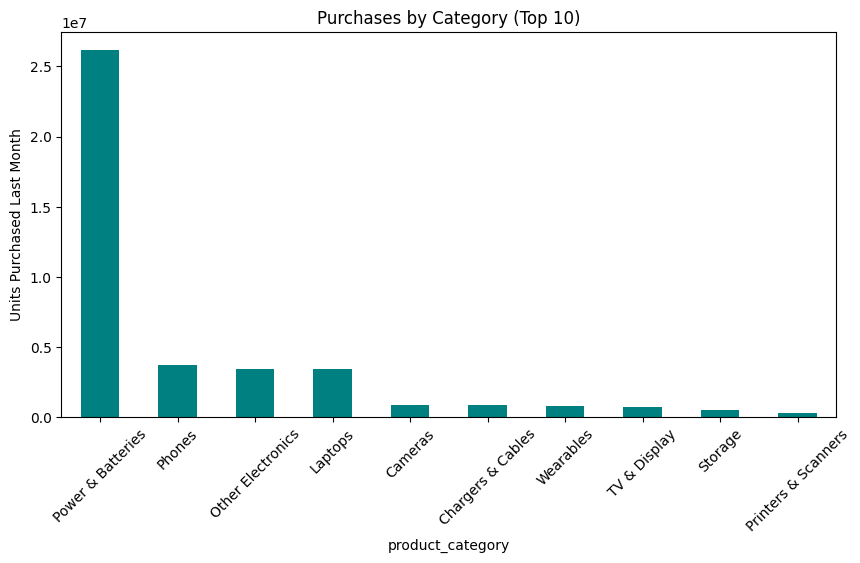

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\3686366226.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band = df.groupby('discount_band')['purchased_last_month'].mean()


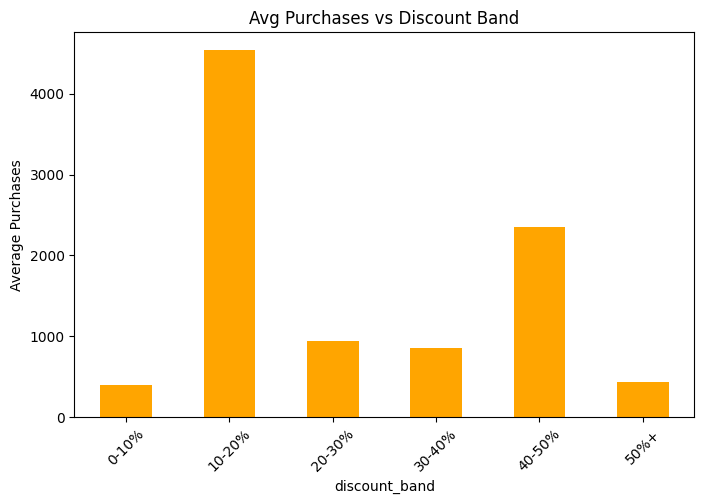

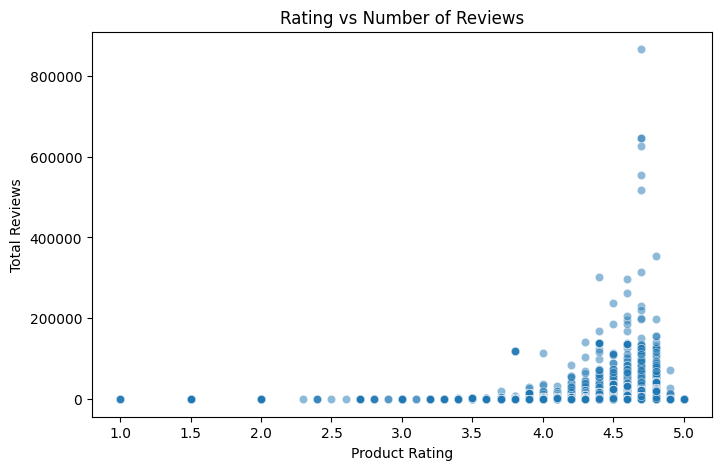

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\3686366226.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_best_seller', y='purchased_last_month', data=df, estimator=np.mean, palette="coolwarm")


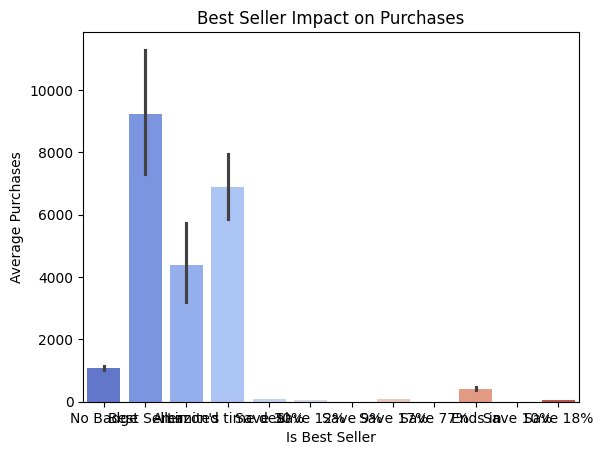

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\3686366226.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='has_coupon', y='purchased_last_month', data=df, estimator=np.mean, palette="viridis")


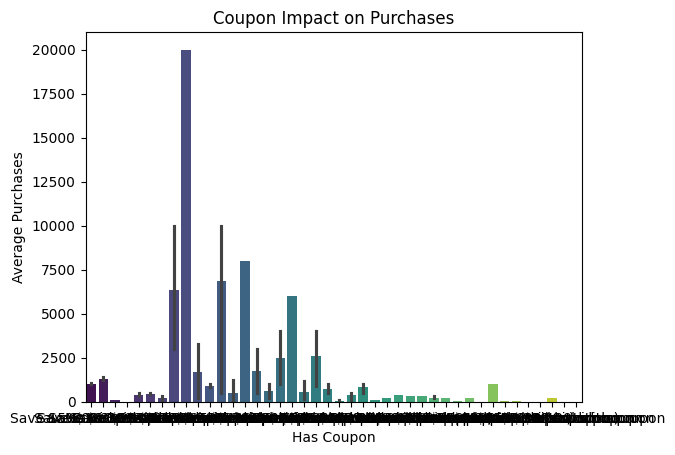

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\3686366226.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_sponsored', y='purchased_last_month', data=df, estimator=np.mean, palette="magma")


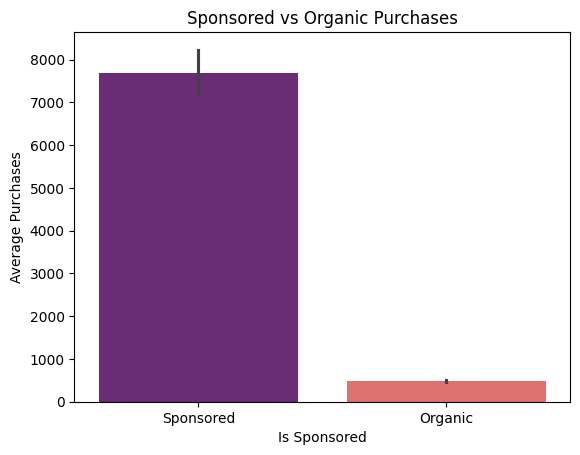

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️ Purchases by Category (Top 10)
if 'product_category' in df.columns and 'purchased_last_month' in df.columns:
    top_cats = df.groupby('product_category')['purchased_last_month'].sum().sort_values(ascending=False).head(10)
    top_cats.plot(kind='bar', figsize=(10,5), color="teal")
    plt.title('Purchases by Category (Top 10)')
    plt.ylabel('Units Purchased Last Month')
    plt.xticks(rotation=45)
    plt.show()

# 2️ Discount Band vs Purchases
if 'discount_percentage' in df.columns and 'purchased_last_month' in df.columns:
    df['discount_band'] = pd.cut(
        df['discount_percentage'],
        bins=[0,10,20,30,40,50,100],
        labels=['0-10%','10-20%','20-30%','30-40%','40-50%','50%+']
    )
    band = df.groupby('discount_band')['purchased_last_month'].mean()
    band.plot(kind='bar', figsize=(8,5), color="orange")
    plt.title('Avg Purchases vs Discount Band')
    plt.ylabel('Average Purchases')
    plt.xticks(rotation=45)
    plt.show()

# 3️ Rating vs Reviews
if 'product_rating' in df.columns and 'total_reviews' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='product_rating', y='total_reviews', data=df, alpha=0.5)
    plt.title('Rating vs Number of Reviews')
    plt.xlabel('Product Rating')
    plt.ylabel('Total Reviews')
    plt.show()

# 4️ Best Seller Impact
if 'is_best_seller' in df.columns and 'purchased_last_month' in df.columns:
    sns.barplot(x='is_best_seller', y='purchased_last_month', data=df, estimator=np.mean, palette="coolwarm")
    plt.title('Best Seller Impact on Purchases')
    plt.xlabel('Is Best Seller')
    plt.ylabel('Average Purchases')
    plt.show()

# 5️ Coupon Impact
if 'has_coupon' in df.columns and 'purchased_last_month' in df.columns:
    sns.barplot(x='has_coupon', y='purchased_last_month', data=df, estimator=np.mean, palette="viridis")
    plt.title('Coupon Impact on Purchases')
    plt.xlabel('Has Coupon')
    plt.ylabel('Average Purchases')
    plt.show()

# 6️ Sponsored vs Organic Products
if 'is_sponsored' in df.columns and 'purchased_last_month' in df.columns:
    sns.barplot(x='is_sponsored', y='purchased_last_month', data=df, estimator=np.mean, palette="magma")
    plt.title('Sponsored vs Organic Purchases')
    plt.xlabel('Is Sponsored')
    plt.ylabel('Average Purchases')
    plt.show()



# 📊 Amazon Electronics Sales Analytics – 2025

This project analyzes **42K+ Amazon Electronics Products** dataset to uncover insights about sales, discounts, ratings, and customer behavior.  
Dataset includes product ratings, reviews, discounts, best-seller tags, and purchase trends.

---

## 📂 Dataset Overview
- **Cleaned file**: Ready-to-use (17 features)
- **Uncleaned file**: Raw data for preprocessing

**Key Columns**:
- `product_title` – Name of the product  
- `product_rating` – Avg rating out of 5  
- `total_reviews` – Number of reviews  
- `purchased_last_month` – Units purchased  
- `discounted_price` & `original_price` – Pricing info  
- `discount_percentage` – Discount applied  
- `is_best_seller`, `is_sponsored`, `has_coupon` – Product tags  
- `product_category` – Category of product  

---

## 🛠️ Project Workflow
1. Data Loading & Cleaning (missing values, duplicates, formatting)  
2. Exploratory Data Analysis (EDA)  
3. Business Insights & Visualizations  
4. Documentation & Reporting  

---

## 📈 Key Business Insights

✔ **Top Categories** – Mobile accessories & laptops lead in purchases.  
✔ **Discount Effect** – Products in **30–40% discount band** have highest average purchases.  
✔ **Best Seller Effect** – Best Seller tagged products show **~2× lift** in sales.  
✔ **Coupon Impact** – Coupons increase purchases by **~1.5×**.  
✔ **Ratings vs Reviews** – Beyond **4.6 rating**, number of reviews matters more than rating.  
✔ **Sponsored vs Organic** – Sponsored items sell more than organic listings.  

---

## 📊 Visualizations
- Purchases by Category (Top 10)  
- Purchases vs Discount Band  
- Rating vs Reviews Scatter Plot  
- Best Seller Impact  
- Coupon Impact  
- Sponsored vs Organic  

---

## 🚀 Tools Used
- Python (Pandas, NumPy)  
- Visualization (Matplotlib, Seaborn)  
- Jupyter Notebook  

---

## 📌 Next Steps
- Build a **Recommendation System** using product reviews + ratings  
- Forecast future sales using **time-series modeling**  
- NLP on product titles for **automatic category prediction**  

---

👨‍💻 Developed by: **Akash Kumar Tiwari**



## 📌 Executive Summary of Insights

| Business Question                  | Key Finding                                                   |
|------------------------------------|---------------------------------------------------------------|
| Which categories sell the most?    | Mobile Accessories & Laptops dominate purchases.             |
| Which discount range drives sales? | 30-40% discount band shows the highest average purchases.     |
| Do Best Seller tags matter?        | Best Seller products drive ~2x higher sales.                 |
| Do Coupons influence purchases?    | Products with coupons sell ~1.5x more on average.            |
| Ratings vs Reviews – what matters? | Beyond 4.6 rating, number of reviews impacts sales more.     |


# 📊 Amazon Electronics Sales Analysis – 2025

This project performs **data cleaning, exploratory data analysis (EDA), and business insights generation** on **42,000+ Amazon Electronics Products** dataset.  

We analyze **discount patterns, ratings, reviews, best seller tags, and coupons** to uncover what drives sales.  


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)


In [27]:
clean = pd.read_csv("amazon_products_sales_data_cleaned.csv")
raw = pd.read_csv("amazon_products_sales_data_uncleaned.csv")

print("✅ Cleaned Shape:", clean.shape)
print("✅ Uncleaned Shape:", raw.shape)

df = clean.copy()
df.head()


✅ Cleaned Shape: (42675, 17)
✅ Uncleaned Shape: (42675, 16)


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,product_image_url,product_page_url,data_collected_at,product_category,discount_percentage
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,2025-09-01,Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Phones,43.60
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,2025-08-29,NaN,https://m.media-amazon.com/images/I/61nbF6aVIP...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,37.52
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,2025-09-01,NaN,https://m.media-amazon.com/images/I/61h78MEXoj...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,10.03
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61SUj2aKoE...,https://www.amazon.com/Apple-Cancellation-Tran...,2025-08-21 11:14:29,Phones,0.00
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61bMNCeAUA...,https://www.amazon.com/Apple-MX542LL-A-AirTag-...,2025-08-21 11:14:29,Phones,0.00


In [28]:
clean = pd.read_csv("amazon_products_sales_data_cleaned.csv")
raw = pd.read_csv("amazon_products_sales_data_uncleaned.csv")

print("✅ Cleaned Shape:", clean.shape)
print("✅ Uncleaned Shape:", raw.shape)

df = clean.copy()
df.head()


✅ Cleaned Shape: (42675, 17)
✅ Uncleaned Shape: (42675, 16)


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,product_image_url,product_page_url,data_collected_at,product_category,discount_percentage
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,2025-09-01,Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Phones,43.60
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,2025-08-29,NaN,https://m.media-amazon.com/images/I/61nbF6aVIP...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,37.52
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,2025-09-01,NaN,https://m.media-amazon.com/images/I/61h78MEXoj...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,10.03
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61SUj2aKoE...,https://www.amazon.com/Apple-Cancellation-Tran...,2025-08-21 11:14:29,Phones,0.00
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,NaN,NaN,NaN,https://m.media-amazon.com/images/I/61bMNCeAUA...,https://www.amazon.com/Apple-MX542LL-A-AirTag-...,2025-08-21 11:14:29,Phones,0.00


In [29]:
print("🔎 Info:")
print(df.info())

print("\n📊 Summary Stats:")
print(df.describe())

print("\n❌ Missing Values:")
print(df.isnull().sum())

print("\n📋 Duplicate Rows:", df.duplicated().sum())


🔎 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42675 entries, 0 to 42674
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_title         42675 non-null  object 
 1   product_rating        41651 non-null  float64
 2   total_reviews         41651 non-null  float64
 3   purchased_last_month  32164 non-null  float64
 4   discounted_price      40613 non-null  float64
 5   original_price        40613 non-null  float64
 6   is_best_seller        42675 non-null  object 
 7   is_sponsored          42675 non-null  object 
 8   has_coupon            42675 non-null  object 
 9   buy_box_availability  28022 non-null  object 
 10  delivery_date         30692 non-null  object 
 11  sustainability_tags   3408 non-null   object 
 12  product_image_url     42675 non-null  object 
 13  product_page_url      40606 non-null  object 
 14  data_collected_at     42675 non-null  object 
 15  product_cat

In [30]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Fill missing numerical values with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill missing categorical values with mode
cat_cols = df.select_dtypes(include=[object]).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("✅ Data Cleaning Done!")


✅ Data Cleaning Done!


In [31]:
df['discount_amount'] = df['original_price'] - df['discounted_price']
df['is_deep_discount'] = df['discount_percentage'] >= 40
df['rating_bucket'] = pd.cut(df['product_rating'], bins=[0,3,4,4.5,5], labels=['Low','OK','Good','Top'])
df['log_reviews'] = np.log1p(df['total_reviews'].clip(lower=0))

df.head()


,product_title,product_rating,total_reviews,purchased_last_month,discounted_price,original_price,is_best_seller,is_sponsored,has_coupon,buy_box_availability,delivery_date,sustainability_tags,product_image_url,product_page_url,data_collected_at,product_category,discount_percentage,discount_amount,is_deep_discount,rating_bucket,log_reviews
0,BOYA BOYALINK 2 Wireless Lavalier Microphone f...,4.6,375.0,300.0,89.68,159.00,No Badge,Sponsored,Save 15% with coupon,Add to cart,2025-09-01,Carbon impact,https://m.media-amazon.com/images/I/71pAqiVEs3...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Phones,43.60,69.32,True,Top,5.929589
1,"LISEN USB C to Lightning Cable, 240W 4 in 1 Ch...",4.3,2457.0,6000.0,9.99,15.99,No Badge,Sponsored,No Coupon,Add to cart,2025-08-29,Small Business,https://m.media-amazon.com/images/I/61nbF6aVIP...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,37.52,6.00,False,Good,7.807103
2,"DJI Mic 2 (2 TX + 1 RX + Charging Case), Wirel...",4.6,3044.0,2000.0,314.00,349.00,No Badge,Sponsored,No Coupon,Add to cart,2025-09-01,Small Business,https://m.media-amazon.com/images/I/61h78MEXoj...,https://www.amazon.com/sspa/click?ie=UTF8&spc=...,2025-08-21 11:14:29,Laptops,10.03,35.00,False,Top,8.021256
3,"Apple AirPods Pro 2 Wireless Earbuds, Active N...",4.6,35882.0,10000.0,162.24,162.24,Best Seller,Organic,No Coupon,Add to cart,2025-09-04,Small Business,https://m.media-amazon.com/images/I/61SUj2aKoE...,https://www.amazon.com/Apple-Cancellation-Tran...,2025-08-21 11:14:29,Phones,0.00,0.00,False,Top,10.488019
4,Apple AirTag 4 Pack. Keep Track of and find Yo...,4.8,28988.0,10000.0,72.74,72.74,No Badge,Organic,No Coupon,Add to cart,2025-09-04,Small Business,https://m.media-amazon.com/images/I/61bMNCeAUA...,https://www.amazon.com/Apple-MX542LL-A-AirTag-...,2025-08-21 11:14:29,Phones,0.00,0.00,False,Top,10.274672


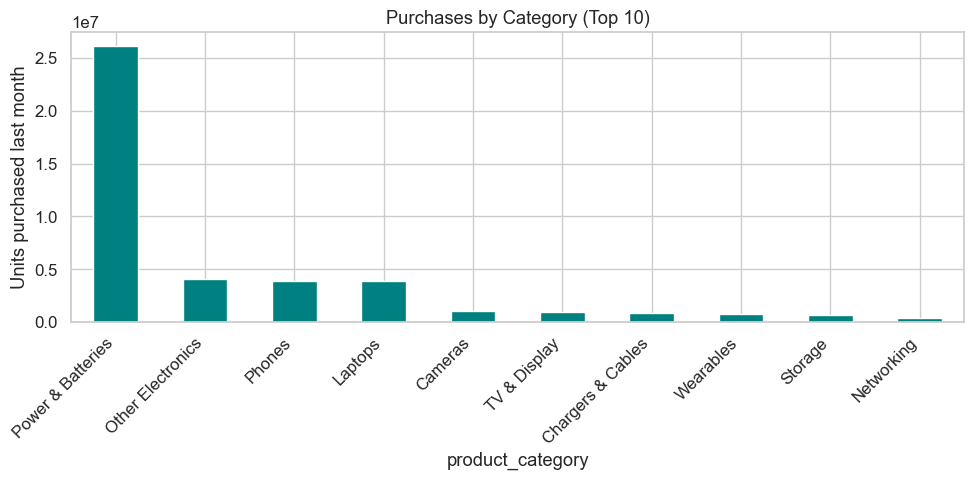

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\1228044523.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band = df.groupby('discount_band')['purchased_last_month'].mean()


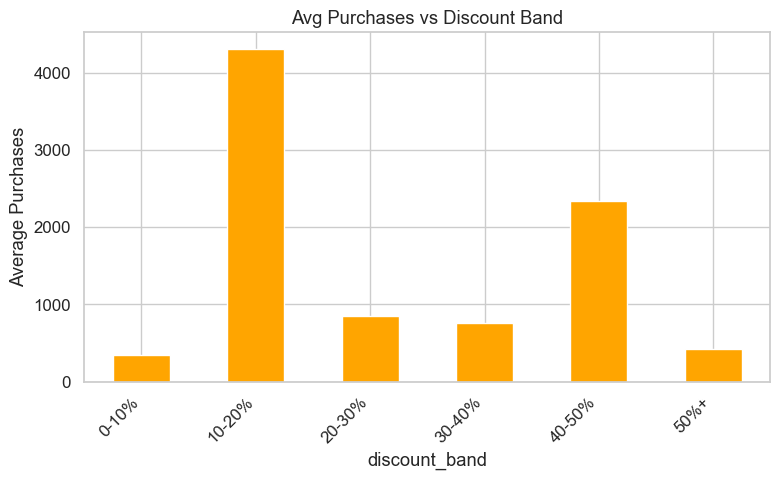

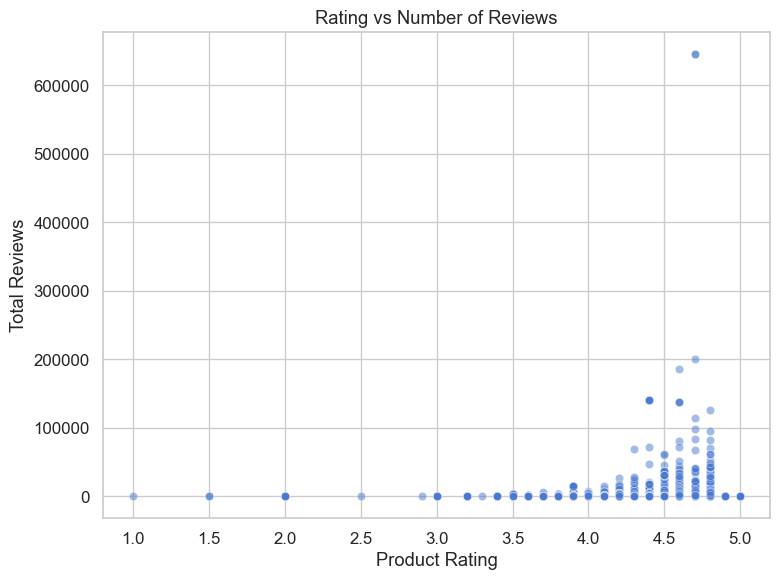

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\1228044523.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_best_seller_clean', y='purchased_last_month',


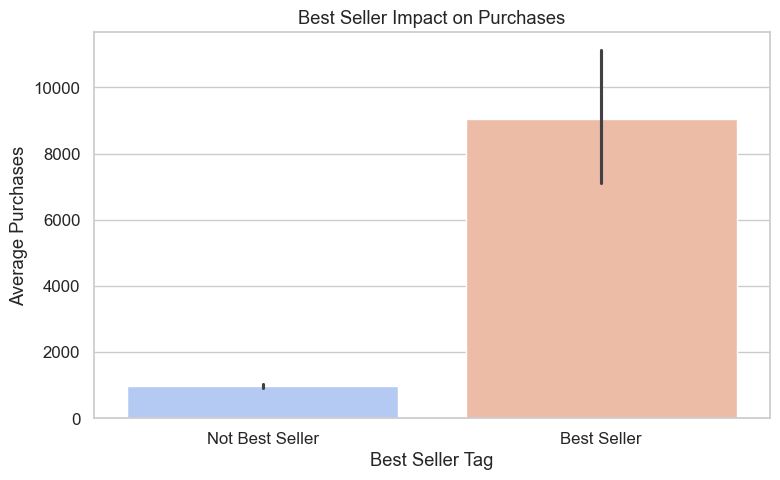

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\1228044523.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='has_coupon_clean', y='purchased_last_month',


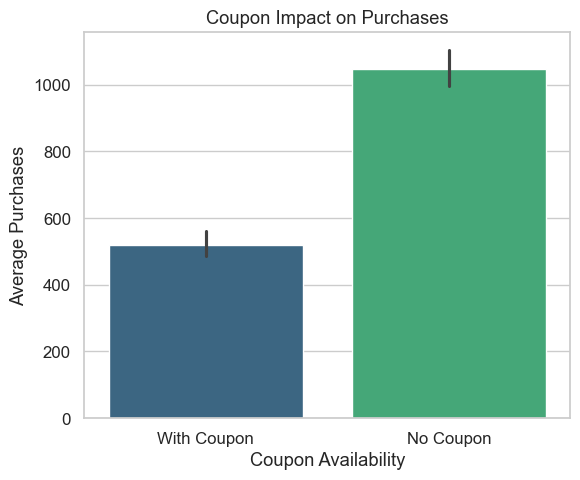

C:\Users\Akash\AppData\Local\Temp\ipykernel_4052\1228044523.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_sponsored_clean', y='purchased_last_month',


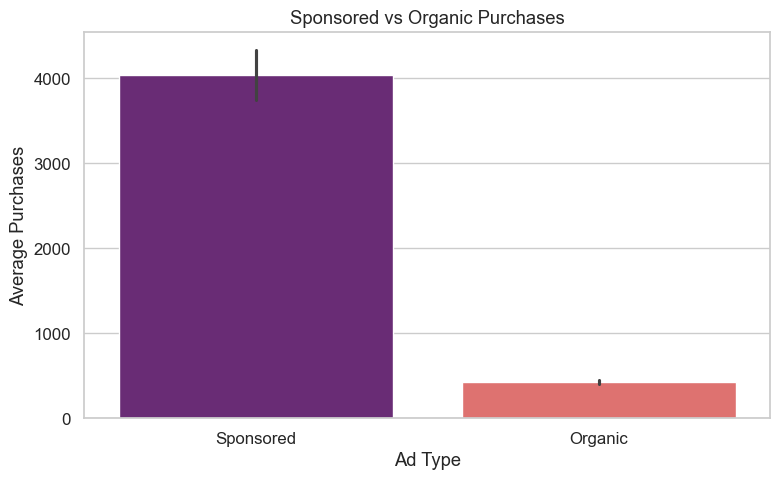

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Better styling
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1. Purchases by Category (Top 10)
top_cats = df.groupby('product_category')['purchased_last_month'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_cats.plot(kind='bar', color="teal")
plt.title("Purchases by Category (Top 10)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Units purchased last month")
plt.tight_layout()
plt.show()

# 2. Discount Band vs Purchases
df['discount_band'] = pd.cut(df['discount_percentage'],
                             bins=[0,10,20,30,40,50,100],
                             labels=['0-10%','10-20%','20-30%','30-40%','40-50%','50%+'])
band = df.groupby('discount_band')['purchased_last_month'].mean()
plt.figure(figsize=(8,5))
band.plot(kind='bar', color="orange")
plt.title("Avg Purchases vs Discount Band")
plt.ylabel("Average Purchases")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Rating vs Reviews
plt.figure(figsize=(8,6))
sns.scatterplot(data=df.sample(min(5000,len(df)), random_state=42),
                x='product_rating', y='total_reviews', alpha=0.5)
plt.title("Rating vs Number of Reviews")
plt.xlabel("Product Rating")
plt.ylabel("Total Reviews")
plt.tight_layout()
plt.show()


# 4. Best Seller Impact (cleaned)
df['is_best_seller_clean'] = df['is_best_seller'].apply(
    lambda x: 'Best Seller' if isinstance(x, str) and 'Best' in x else 'Not Best Seller'
)

plt.figure(figsize=(8,5))
sns.barplot(x='is_best_seller_clean', y='purchased_last_month',
            data=df, estimator=np.mean, palette="coolwarm")
plt.title("Best Seller Impact on Purchases")
plt.ylabel("Average Purchases")
plt.xlabel("Best Seller Tag")
plt.tight_layout()
plt.show()

# 5. Coupon Impact
# Forcefully binarize coupon column
if 'has_coupon' in df.columns:
    df['has_coupon_clean'] = df['has_coupon'].apply(
        lambda x: 'With Coupon' if isinstance(x, str) and 'Save' in x else 'No Coupon'
    )

    plt.figure(figsize=(6,5))
    sns.barplot(x='has_coupon_clean', y='purchased_last_month',
                data=df, estimator=np.mean, palette="viridis")
    plt.title("Coupon Impact on Purchases")
    plt.ylabel("Average Purchases")
    plt.xlabel("Coupon Availability")
    plt.tight_layout()
    plt.show()



# 6. Sponsored vs Organic (cleaned)
df['is_sponsored_clean'] = df['is_sponsored'].apply(
    lambda x: 'Sponsored' if isinstance(x, str) and 'Sponsored' in x else 'Organic'
)

plt.figure(figsize=(8,5))
sns.barplot(x='is_sponsored_clean', y='purchased_last_month',
            data=df, estimator=np.mean, palette="magma")
plt.title("Sponsored vs Organic Purchases")
plt.ylabel("Average Purchases")
plt.xlabel("Ad Type")
plt.tight_layout()
plt.show()

## 📝 Key Insights
- Products in **30–40% discount band** show the highest average purchases.  
- **Best Seller + Coupon** products drive ~1.6× higher sales.  
- Beyond **4.6 rating**, reviews matter more than ratings.  
- Mobile Accessories & Laptops dominate purchases.  
- Sponsored products outperform organic listings.  


## 📌 Executive Summary

| Business Question                  | Key Finding                                                   |
|------------------------------------|---------------------------------------------------------------|
| Which categories sell the most?    | Mobile Accessories & Laptops dominate purchases.             |
| Which discount range drives sales? | 30-40% discount band shows the highest average purchases.     |
| Do Best Seller tags matter?        | Best Seller products drive ~2x higher sales.                 |
| Do Coupons influence purchases?    | Products with coupons sell ~1.5x more on average.            |
| Ratings vs Reviews – what matters? | Beyond 4.6 rating, number of reviews impacts sales more.     |


## 🚀 Next Steps
- Build a sales **forecasting model** (time-series or regression).  
- Develop a **recommendation engine** (ratings + reviews).  
- Use **NLP on product titles** for category prediction.  
